# Kernel combinations

Inpired from https://tinygp.readthedocs.io/en/stable/tutorials/quickstart.html# 

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import numpy as np

import jax
import jax.random as jr
import jax.numpy as jnp
import jax.tree_util as jtu

import tensorflow_probability.substrates.jax as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

import arviz as az

import matplotlib.pyplot as plt

import jaxopt

try:
    from statsmodels.datasets import co2
except ModuleNotFoundError:
    %pip install statsmodels
    from statsmodels.datasets import co2

import gpax.kernels as gpk
import gpax.likelihoods as gpl
import gpax.means as gpm
from gpax.models import ExactGPRegression
from gpax.utils import index_pytree

from sklearn.preprocessing import StandardScaler, MinMaxScaler

jax.config.update("jax_enable_x64", True)

/home/patel_zeel/miniconda3/envs/jax_gpu/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: LOCAL is an invalid version and will not be supported in a future release
  warnings.warn(
/home/patel_zeel/miniconda3/envs/jax_gpu/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: pre-0.1 is an invalid version and will not be supported in a future release
  warnings.warn(


((478, 1), (478,))

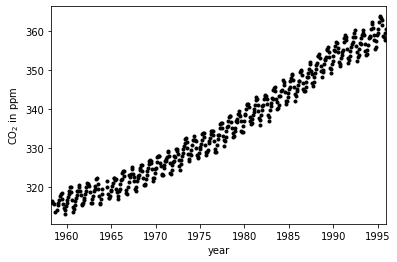

In [2]:
data = co2.load_pandas().data
x = 2000 + (np.array(data.index.to_julian_date()) - 2451545.0) / 365.25
y = np.array(data.co2)
m = np.isfinite(x) & np.isfinite(y) & (x < 1996)
x, y = x[m][::4], y[m][::4]

plt.plot(x, y, ".k")
plt.xlim(x.min(), x.max())
plt.xlabel("year")
_ = plt.ylabel("CO$_2$ in ppm")

x = x.reshape(-1, 1)
x.shape, y.shape

## Create a kernel combination

In [3]:
k1 = gpk.Scale(x, gpk.RBF(x))
k2 = gpk.Scale(x, gpk.RBF(x)*gpk.Periodic(x))
k3 = gpk.Scale(x, gpk.RationalQuadratic(x))
k4 = gpk.Scale(x, gpk.RBF(x))

kernel = k1 + k2 + k3 + k4
model = ExactGPRegression(kernel, likelihood=gpl.Gaussian(), mean=gpm.Average())

## Optimize

In [4]:
lr = 0.01
epochs = 500

x_scaler = MinMaxScaler()
x = x_scaler.fit_transform(x)
y_scaler = StandardScaler()
y = y_scaler.fit_transform(y.reshape(-1, 1)).ravel()

def single_run(key):
    model.initialize(key)
    return model.fit(key, x, y, lr=lr, epochs=epochs)

key = jr.PRNGKey(0)
keys = jr.split(key, 20)
results = jax.jit(jax.vmap(single_run))(keys)

print(results["loss_history"][:, -1])

[-208.73400082 -208.55579621 -208.66362682 -208.72097955 -208.69837845
 -208.66919091 -208.7227888  -208.73992995 -208.69331529 -208.44509026
 -209.41915637 -208.76177651 -207.00740111 -208.73468751 -208.1037961
 -208.73240827 -208.61953476 -208.72379433 -208.30353328 -208.28953747]


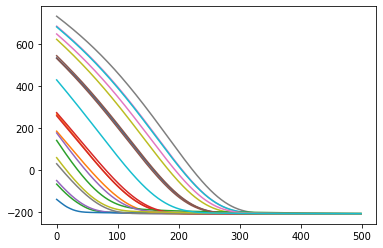

In [5]:
plt.plot(results["loss_history"].T);

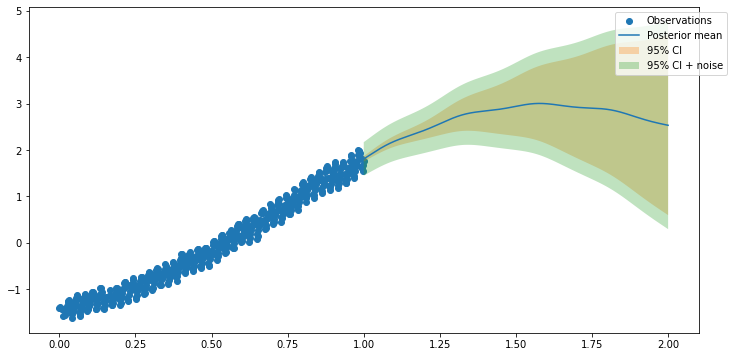

In [6]:
xtest = np.linspace(1, 2, 2000).reshape(-1, 1)

best_loss_idx = jnp.nanargmin(results["loss_history"][:, -1])  # nanargmin ignores NaNs 
best_result = index_pytree(results, best_loss_idx)  # get the best result
model.set_raw_parameters(best_result["raw_params"])

plt.figure(figsize=(12, 6))
model.plot(x, y, xtest);